# Testing single cell simulations to estimate mean I and Var(I)

We want to check if we can have the same information form long protocols compared to multiple experiments, to get the parabola type realtionship between Mean and Var(I).

For this, I'll simulate a protocol with multiple long steps to get different st. st. current values, and then calculate the mean and variance at st.st., and compare if we get the parabola.


Ideas:
- Something similar to what Chon did with the stair protocol but longer steps.

To do: 
- protocol file for miokit
- what steps make sense?
- how long till st. st.
- parabola



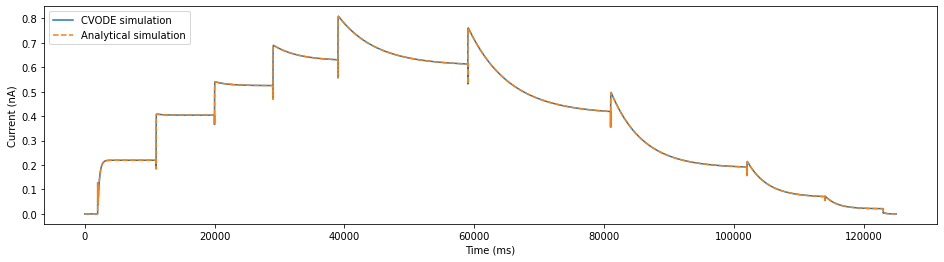

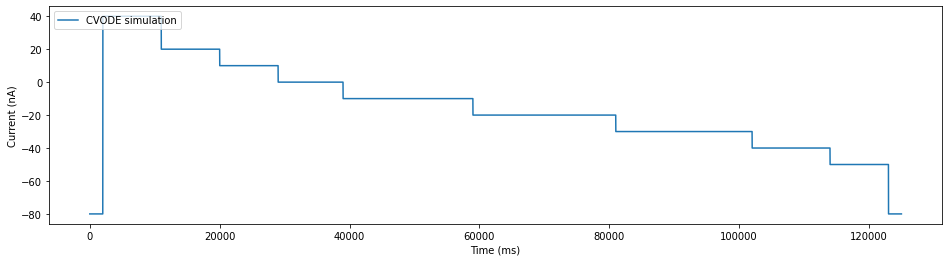

In [15]:
import matplotlib.pyplot as plt
import numpy as np

import myokit
import myokit.lib.markov

from scipy.interpolate import interp1d

# Load a model: this is the same model as before, but coded up as a Markov model (a kinetic scheme)
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')

# Load a protocol
protocol = myokit.load_protocol('resources/long-staircase.mmt')

# Create a parametrisable Hodgkin-Huxley model
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]
markov_model = myokit.lib.markov.LinearModel.from_component(model.get('ikr'), parameters=parameters)

# Create an analytical simulation
markov_sim = myokit.lib.markov.AnalyticalSimulation(markov_model, protocol)

# Create a CVODE simulation
cvode_sim = myokit.Simulation(model, protocol)

# Select times to log
tmax = 125000
times = np.arange(0, tmax, 0.1)

# Run a timed simulation with each method:
b = myokit.Benchmarker()
hh_log = markov_sim.run(tmax, log_times=times)

b.reset()
cvode_log = cvode_sim.run(tmax, log_times=times, log=['ikr.IKr'])


plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, hh_log['ikr.IKr'], '-', label='CVODE simulation')
plt.plot(times, cvode_log['ikr.IKr'], '--', label='Analytical simulation')
plt.legend(loc='upper left')


plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, hh_log['membrane.V'], '-', label='CVODE simulation')
plt.legend(loc='upper left')

plt.show()

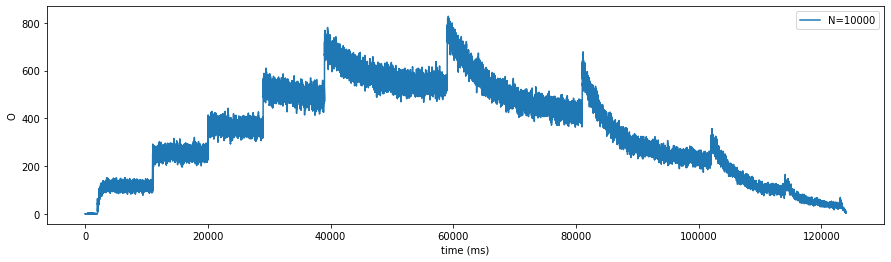

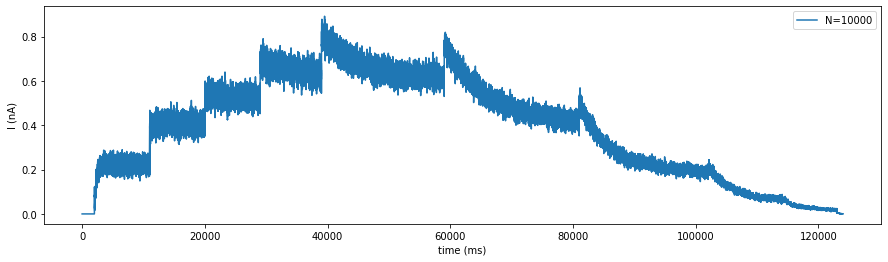

In [18]:
tlog = 124000
N = 10000
m=1
seed_m = 1
time_grid = np.arange(0, tlog, 0.1) 
O_grid= np.zeros([m,tlog*10])
#I_grid_N104m1= np.zeros([m,tlog*10])

# define the model 
sim_long = myokit.lib.markov.DiscreteSimulation(markov_model, protocol, nchannels = N)

# Simulate
np.random.seed(seed_m)
log_long = sim_long.run(tlog)
O = np.array(log_long['ikr.y3']) 
I = np.array(log_long['ikr.IKr'])
time_full = np.array(log_long['engine.time'])
O_inter = interp1d(time_full, O,'previous', fill_value = "extrapolate")
O_grid[0,:] = O_inter(time_grid)

plt.figure(figsize=(15,4))
plt.plot(time_full, O, drawstyle='steps-post', label='N='+str(N))
plt.xlabel('time (ms)')
plt.ylabel('O')
plt.legend()

plt.figure(figsize=(15,4))
plt.plot(time_full, I, drawstyle='steps-post', label='N='+str(N))
plt.xlabel('time (ms)')
plt.ylabel('I (nA)')
plt.legend()

plt.show()

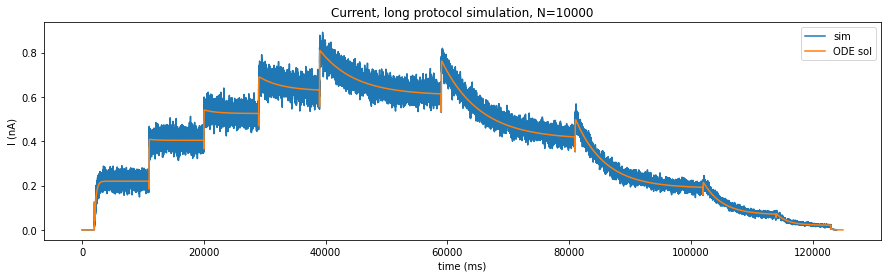

In [19]:
plt.figure(figsize=(15,4))
plt.plot(time_full, I, drawstyle='steps-post', label='sim full')
plt.plot(times, hh_log['ikr.IKr'], '-', label='ODE sol')
plt.xlabel('time (ms)')
plt.ylabel('I (nA)')
plt.title('Current, long protocol simulation, N='+str(N))
plt.legend()

plt.show()

## Divide the data into st. st. periods

We will do mean/var but not in the full simulation, but on the bits that look like st st had reach. My first try will be by eye:

Voltage intervals:

-80     0       2000     
40      next    9000     [2000,11000]   
20      next    9000     [11000,20000]   
10      next    9000     [20000,29000]   
0       next    10000    [29000,39000]  
-10     next    20000    [39000,59000]  
-20     next    22000    [59000,81000]   
-30     next    21000    [81000,102000]   
-40     next    12000    [102000,114000]   
-50     next    9000     [114000,123000]   
-80     next    2000    [123000,125000]    

Time intervals where the current seems to reach st st _by eye_:

1. 3000,10900
2. 12000,19900
3. 22000,28900
4. 34000,38900
5. 50000,58900
6. 75000,80900
7. 94000,101900
8. 110000,113900
9. 119000,122900



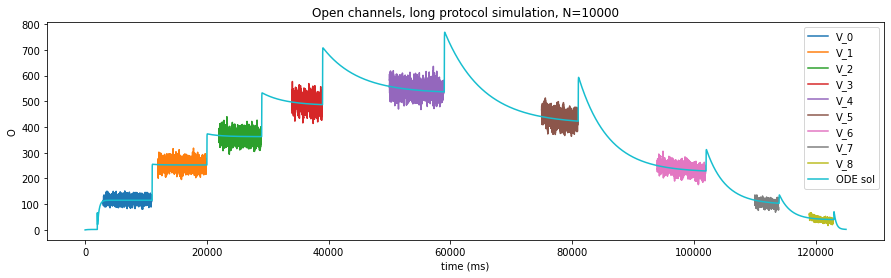

In [70]:
# time intervals lower bound/ upper bound
time_lower = [3000,12000,22000,34000,50000,75000,94000,110000,119000]
time_upper = [10900, 19900,28900,38900,58900,80900,101900,113900,122900]

StSt_opens = []
StSt_times = []
StSt_mean = []
StSt_var = []

for i in range(9): 
    StSt_opens.append(O_grid[0,time_lower[i]*10:time_upper[i]*10])
    StSt_times.append(time_grid[time_lower[i]*10:time_upper[i]*10])
    StSt_mean.append(np.mean(StSt_opens[i]))
    StSt_var.append(np.var(StSt_opens[i]))
plt.figure(figsize=(15,4))
for i in range(9): 
    plt.plot(StSt_times[i], StSt_opens[i], drawstyle='steps-post', label='V_'+str(i))
plt.plot(times, hh_log['ikr.y3']*N, '-', label='ODE sol')
plt.xlabel('time (ms)')
plt.ylabel('O')
plt.title('Open channels, long protocol simulation, N='+str(N))
plt.legend()

plt.show()

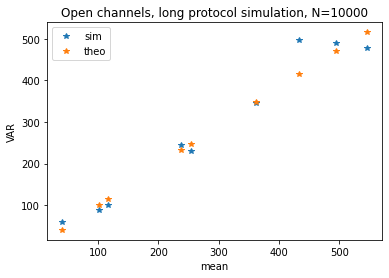

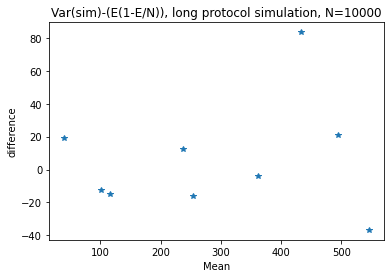

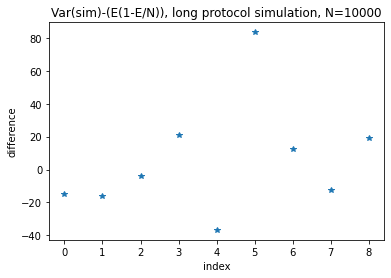

In [91]:

plt.figure()
plt.plot(StSt_mean,StSt_var,'*',label='sim')
plt.plot(np.array(StSt_mean),np.array(StSt_mean)*(1-np.array(StSt_mean)/N),'*',label='theo')
plt.xlabel('mean')
plt.ylabel('VAR')
plt.legend()
plt.title('Open channels, long protocol simulation, N='+str(N))


plt.figure()
plt.plot(StSt_mean,np.array(StSt_var)-(np.array(StSt_mean)*(1-np.array(StSt_mean)/N)),'*')
plt.xlabel('Mean')
plt.ylabel('difference')
plt.title('Var(sim)-(E(1-E/N)), long protocol simulation, N='+str(N))


plt.figure()
plt.plot(np.array(StSt_var)-(np.array(StSt_mean)*(1-np.array(StSt_mean)/N)),'*')
plt.xlabel('index')
plt.ylabel('difference')
plt.title('Var(sim)-(E(1-E/N)), long protocol simulation, N='+str(N))




plt.show()